In [1]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import csv
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Activation, Dense, Dropout
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [4]:
# Importing IMDb Movie Reviews dataset
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv", on_bad_lines='skip', engine="python")

In [5]:
# Dataset exploration
movie_reviews.shape

(13418, 2)

In [6]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# Checking for missing values
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

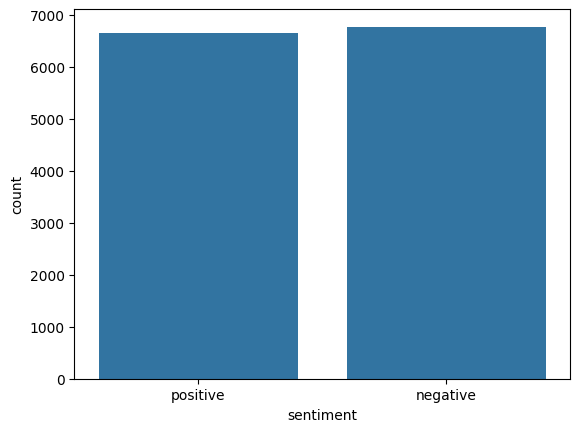

In [8]:
# Let's observe distribution of positive / negative sentiments in dataset
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [40]:
#un-processed raw text
movie_reviews["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [10]:
#removing HTML tags
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
#Pre-processing text
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
# Calling preprocessing_text function on movie_reviews
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
# Sample cleaned up movie review
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [15]:
# Converting sentiment labels to 0 & 1
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [16]:
#splitting into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [17]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [18]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

53647

In [19]:
# Padding all reviews to fixed length 100
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [30]:
# Load GloVe word embeddings and create an Embeddings Dictionary
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

target_length = 100
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [31]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [32]:
embedding_matrix.shape

(53647, 100)

In [33]:
from keras.layers import LSTM

In [34]:
# Neural Network architecture
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [43]:
# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5364700   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5482077 (20.91 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 5364700 (20.46 MB)
_________________________________________________________________
None


In [39]:
# Model Training
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
68/68 [==============================] - 25s 369ms/step - loss: 0.3781 - acc: 0.8375 - val_loss: 0.4452 - val_acc: 0.8058
Epoch 2/10
68/68 [==============================] - 28s 417ms/step - loss: 0.3575 - acc: 0.8424 - val_loss: 0.4367 - val_acc: 0.8160
Epoch 3/10
68/68 [==============================] - 29s 435ms/step - loss: 0.3516 - acc: 0.8471 - val_loss: 0.4161 - val_acc: 0.8156
Epoch 4/10
68/68 [==============================] - 27s 397ms/step - loss: 0.3356 - acc: 0.8636 - val_loss: 0.4078 - val_acc: 0.8249
Epoch 5/10
68/68 [==============================] - 34s 499ms/step - loss: 0.3161 - acc: 0.8676 - val_loss: 0.3786 - val_acc: 0.8365
Epoch 6/10
68/68 [==============================] - 31s 463ms/step - loss: 0.3021 - acc: 0.8778 - val_loss: 0.3722 - val_acc: 0.8402
Epoch 7/10
68/68 [==============================] - 32s 465ms/step - loss: 0.2796 - acc: 0.8875 - val_loss: 0.3869 - val_acc: 0.8407
Epoch 8/10
68/68 [==============================] - 33s 479ms/step - 

In [41]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

84/84 [==============================] - 4s 49ms/step - loss: 0.3957 - acc: 0.8290


In [44]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# Assuming vocab_length, maxlen, X_train, y_train, X_test, y_test, and embedding_matrix are predefined

def create_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

# Define the range of epochs to try
epoch_values = [10, 20, 30, 40, 50]
best_epoch = 0
best_val_acc = 0.0

for epochs in epoch_values:
    print(f"\nTraining model with {epochs} epochs...\n")

    model = create_model()

    # Early stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping])

    val_acc = max(history.history['val_acc'])

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epochs

    print(f"Finished training with {epochs} epochs. Best validation accuracy: {val_acc}")

print(f"\nBest number of epochs: {best_epoch} with validation accuracy: {best_val_acc}")

# Train final model with the best number of epochs
final_model = create_model()
final_model.fit(X_train, y_train, batch_size=128, epochs=best_epoch, verbose=1, validation_split=0.2)

# Evaluate the final model on the test set
score = final_model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")



Training model with 10 epochs...

Epoch 1/10
68/68 [==============================] - 29s 382ms/step - loss: 0.6319 - acc: 0.6485 - val_loss: 0.5610 - val_acc: 0.7513
Epoch 2/10
68/68 [==============================] - 23s 342ms/step - loss: 0.5141 - acc: 0.7687 - val_loss: 0.4920 - val_acc: 0.7834
Epoch 3/10
68/68 [==============================] - 23s 346ms/step - loss: 0.4633 - acc: 0.7924 - val_loss: 0.4758 - val_acc: 0.7923
Epoch 4/10
68/68 [==============================] - 25s 374ms/step - loss: 0.4534 - acc: 0.8014 - val_loss: 0.4471 - val_acc: 0.7946
Epoch 5/10
68/68 [==============================] - 23s 336ms/step - loss: 0.4224 - acc: 0.8138 - val_loss: 0.4542 - val_acc: 0.7881
Epoch 6/10
68/68 [==============================] - 28s 420ms/step - loss: 0.4131 - acc: 0.8230 - val_loss: 0.4314 - val_acc: 0.8090
Epoch 7/10
68/68 [==============================] - 25s 360ms/step - loss: 0.3764 - acc: 0.8375 - val_loss: 0.4083 - val_acc: 0.8277
Epoch 8/10
68/68 [================

In [42]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.39567649364471436
Test Accuracy: 0.8289865851402283
